## import libraries

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from resnet import ResNet18
from loss import calculate_only_belief_uncertainity_ignorance_confusion
from plot import remove_module_name_from_model, plot_test_confusion_ignorance_for_samples_with_images_cifar_10

In [2]:
# define transforms
cifar_10_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))
])

# define testset
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=cifar_10_test_transform)

cifar_10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_classes = 10

Files already downloaded and verified


In [3]:
# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
cifar_10_pretrained_model_path = "cifar_10_pretrained.pth"

# load the model
model = ResNet18()

model.load_state_dict(remove_module_name_from_model(torch.load(cifar_10_pretrained_model_path)["net"]))

# set the model to evaluation mode
model.eval()

# print parameter count
print(f"Parameter count: {sum(p.numel() for p in model.parameters())}")

Parameter count: 11173962


## Get test accuracy and AUROC score

In [5]:
# set the model to device
model.to(device)

# create testloader
testloader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=2)

# initialize the accuracy and auroc score
test_accuracy = 0
total = 0
correct = 0
test_auroc_score = 0

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        

        _, predicted = outputs.max(1)

        test_auroc_score += roc_auc_score(F.one_hot(targets, num_classes=num_classes).cpu().detach().numpy(), outputs.cpu().detach().numpy(), multi_class='ovr')

        test_accuracy += predicted.eq(targets).sum().item() / targets.size(0)

model = model.to(device)

# print the accuracy and auroc score
print(f"Test Accuracy: {test_accuracy/(len(testloader)):.4f}, Test AUROC Score: {test_auroc_score/(len(testloader)):.4f}")


Test Accuracy: 0.9396, Test AUROC Score: 0.9963


## Get qualitative results

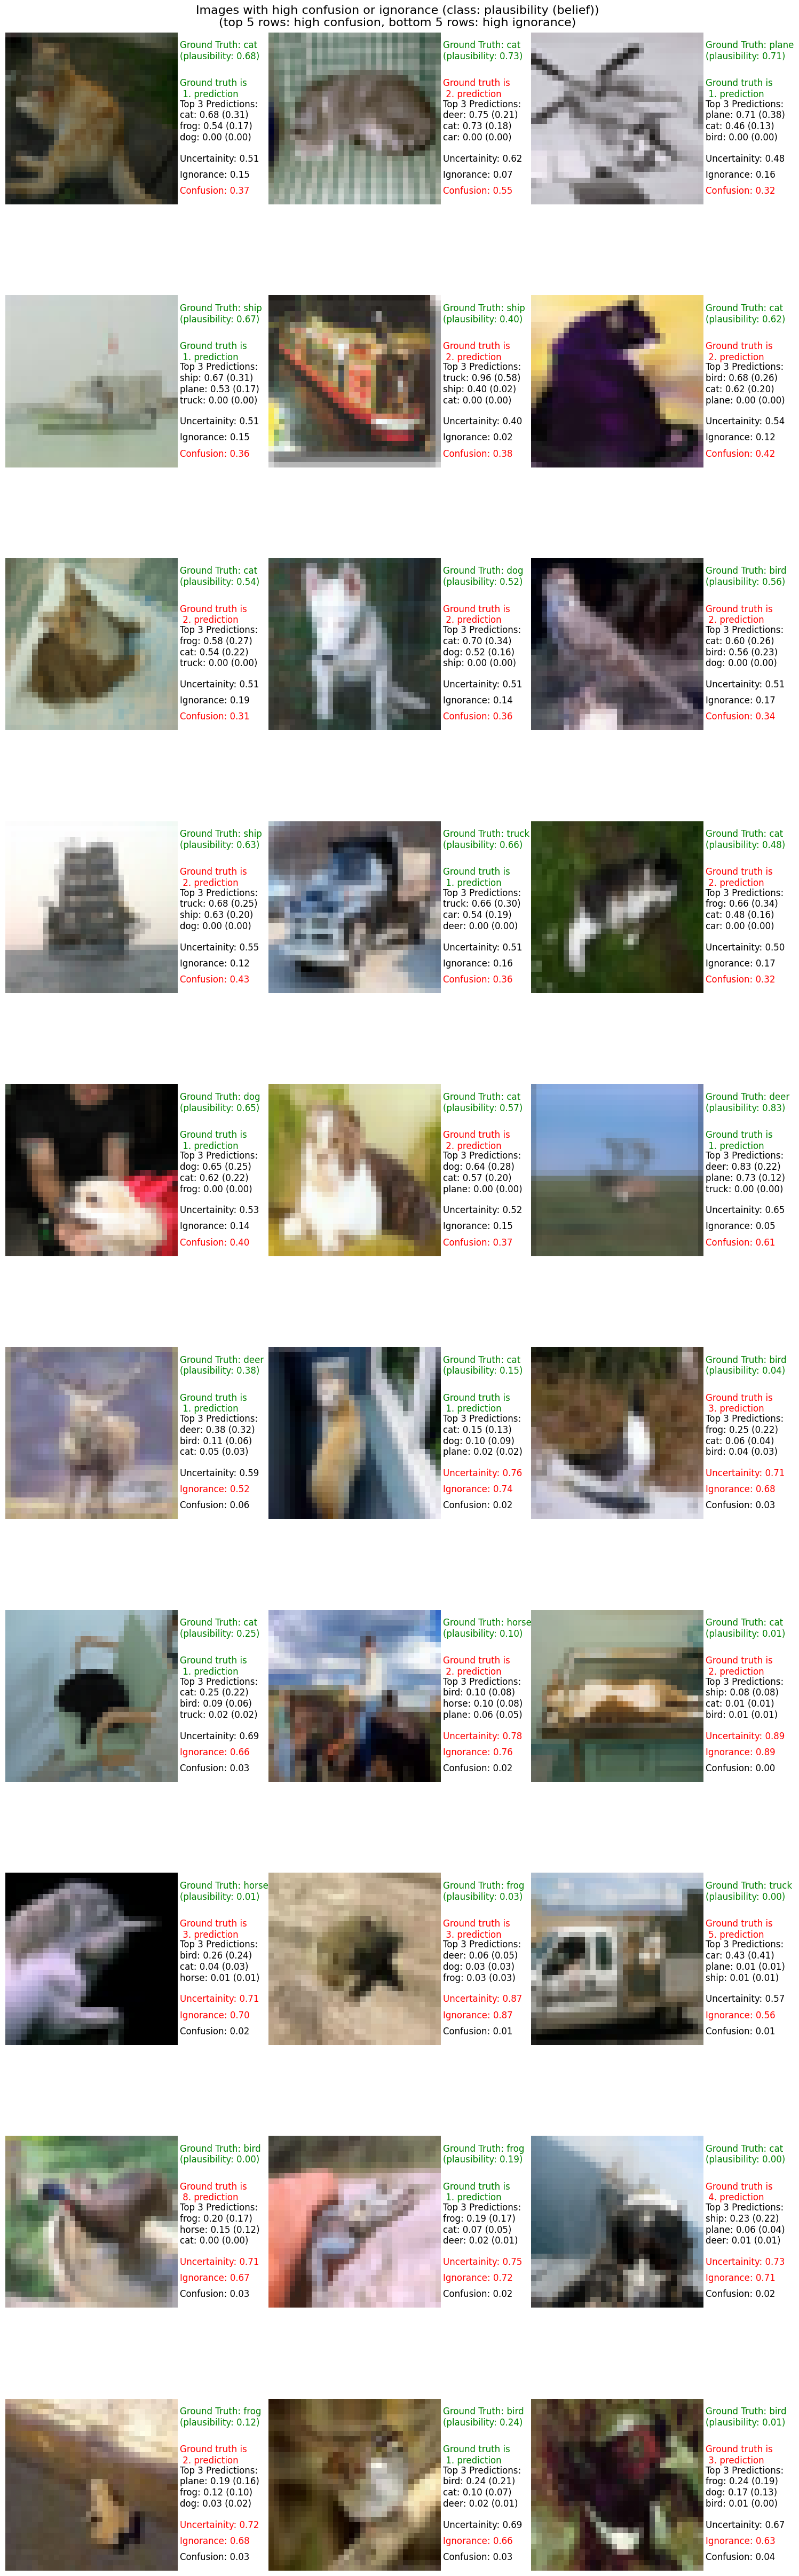

In [6]:
plot_test_confusion_ignorance_for_samples_with_images_cifar_10(
    testset=testset,
    model=model,
    device=device,
    cifar_10_classes=cifar_10_classes,
    save_path="test/cifar10_sample_output.png",
    images_to_plot_count_width=3,
    images_to_plot_count_height=10,
    uncertainty_threshold=0.7, # just to make it red
    confusion_threshold=0.3, # to pick the most confused samples
    ignorance_threshold=0.5, # to pick the most ignorant samples
)

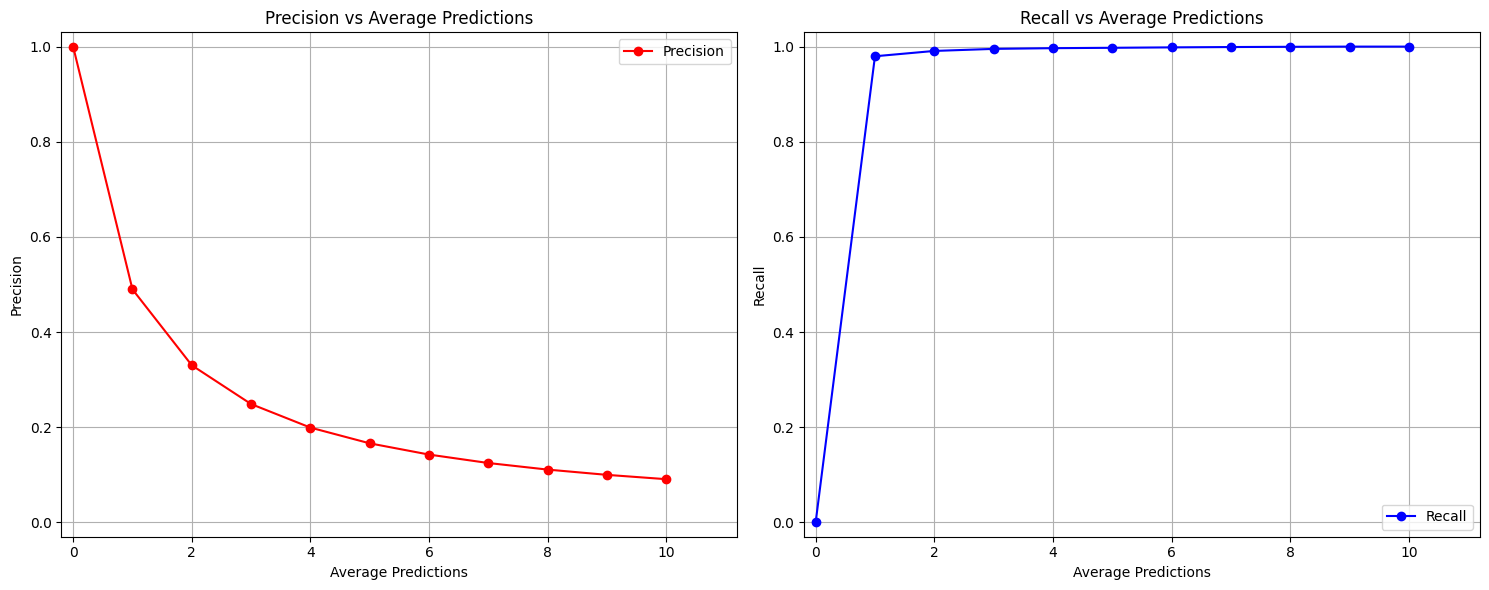

In [7]:
# for the all samples in the test set, calculate the top-x precision and recall (for all x) and plot them
n_classes = 10

len_testset = len(testset)

# create a tensor to store the precision values (from 0 to n_classes-1)
prediction_gt_position = torch.zeros(len_testset)

# set the model to device and evaluation mode
model.to(device)
model.eval()

# iterate over the test set
with torch.no_grad():
    for i, data in enumerate(testset):

        image, label = data
        image = image.unsqueeze(0).to(device)
        label = torch.tensor([label]).to(device)

        # forward pass
        output = model(image)

        # pass the output through sigmoid
        output = torch.sigmoid(output)

        # argsort the output
        _, indices = torch.sort(output, descending=True)

        # calculate the position of the ground truth class in the output tensor
        label_index = (indices[0] == label).nonzero(as_tuple=True)[0]

        # save the position
        prediction_gt_position[i] = label_index

model.to('cpu')

# calculate the precision values
precision_values = torch.zeros(n_classes+1)
recall_values = torch.zeros(n_classes+1)

# set the first values
precision_values[0] = 1
recall_values[0] = 0

for i in range(1, n_classes + 1):

    # calculate the precision
    precision_values[i] = (prediction_gt_position <= i).sum() / (len_testset * (i + 1))

    # calculate the recall
    recall_values[i] = (prediction_gt_position <= i).sum() / len_testset

# create a 1x2 plot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# plot the precision values
ax[0].plot(range(0, n_classes + 1), precision_values, label="Precision", color="red", marker="o")
ax[0].set_xlabel("Average Predictions")
ax[0].set_ylabel("Precision")
ax[0].set_xlim(-0.2, n_classes + 1.2)
ax[0].set_ylim(-0.03, 1.03)
ax[0].legend()
ax[0].grid()
ax[0].set_title("Precision vs Average Predictions")

# plot the recall values
ax[1].plot(range(0, n_classes + 1), recall_values, label="Recall", color="blue", marker="o")
ax[1].set_xlabel("Average Predictions")
ax[1].set_ylabel("Recall")
ax[1].set_xlim(-0.2, n_classes + 1.2)
ax[1].set_ylim(-0.03, 1.03)
ax[1].legend()
ax[1].grid()
ax[1].set_title("Recall vs Average Predictions")


# tight layout
plt.tight_layout()

# save the plot
plt.savefig("test/cifar10_precision_recall.png")

# show the plot
plt.show()

